# EC-TEL 2015 Learning Analytics Workshop

### Lalitha Agnihotri, Alfred Essa, Shirin Mojarad
#### McGraw-Hill Education

# Modeling and classification

Next step after EDA is to create a model. The type of model depends on the task at hand such as prediction, classification, segmentation, etc. There are few steps to take for creating a machine learning model:

- Pre-processig
- Define input and output features
- Split the data into trainin and test
- Create a model using training set
- Validate the model using test set
- Create and compare feature sets/models

# Import libraries

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

%matplotlib inline

#k-means clustering
from scipy.cluster.vq import kmeans,vq
from sklearn import preprocessing
from sklearn.cluster import KMeans

# PLOTLY
import plotly.plotly as py
from plotly.graph_objs import *

from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn import metrics
from sklearn import ensemble

from scipy import interp
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import StratifiedKFold
from scipy.stats.stats import pearsonr

from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets
from sklearn.naive_bayes import GaussianNB as gnb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier as rfc
import random 
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import precision_recall_fscore_support 

# Load data

In [2]:
edx = pd.read_csv('edx.csv',  parse_dates=['start_time_DI','last_event_DI'])
edx = edx.rename(columns={'final_cc_cname_DI':'country', 'userid_DI':'user_id', 'YoB': 'BirthYear','LoE_DI':'LevelofEducation'  })
edx.head()

,course_id,user_id,registered,viewed,explored,certified,country,LevelofEducation,BirthYear,gender,grade,start_time_DI,last_event_DI,nevents,ndays_act,nplay_video,nchapters,nforum_posts,roles,incomplete_flag
0,HarvardX/CB22x/2013_Spring,MHxPC130442623,1,0,0,0,United States,NaN,NaN,NaN,0,2012-12-19,2013-11-17,NaN,9,NaN,NaN,0,NaN,1
1,HarvardX/CS50x/2012,MHxPC130442623,1,1,0,0,United States,NaN,NaN,NaN,0,2012-10-15,NaT,NaN,9,NaN,1,0,NaN,1
2,HarvardX/CB22x/2013_Spring,MHxPC130275857,1,0,0,0,United States,NaN,NaN,NaN,0,2013-02-08,2013-11-17,NaN,16,NaN,NaN,0,NaN,1
3,HarvardX/CS50x/2012,MHxPC130275857,1,0,0,0,United States,NaN,NaN,NaN,0,2012-09-17,NaT,NaN,16,NaN,NaN,0,NaN,1
4,HarvardX/ER22x/2013_Spring,MHxPC130275857,1,0,0,0,United States,NaN,NaN,NaN,0,2012-12-19,NaT,NaN,16,NaN,NaN,0,NaN,1


## Pre-processing

In [3]:
# Fill NaN
edx.fillna(0, inplace=True)

In [4]:
# Age
edx = edx[edx.BirthYear<>0]
edx = edx[edx.BirthYear<=2004]
edx['Age'] = edx['BirthYear'].apply(lambda x: 2012 - x)

In [5]:
# country
english_speaking = ['United States','Australia','India','Canada'
                    ,'United Kingdom', 'Nigeria']

nonenglish_speaking = ['France', 'Unknown/Other', 'Mexico','Russian Federation', 'Other South Asia',
       'Other North & Central Amer., Caribbean', 'Other Europe',
       'Other Oceania', 'Japan', 'Other Africa', 'Colombia', 'Germany',
       'Other Middle East/Central Asia', 'Poland', 'Indonesia',
       'Other East Asia', 'Bangladesh', 'China',
       'Ukraine', 'Spain', 'Greece', 'Pakistan', 'Brazil',
       'Egypt', 'Other South America', 'Portugal', 'Philippines', 'Morocco']

eng_map = dict(zip(english_speaking,np.ones(len(english_speaking))))
noneng_map = dict(zip(nonenglish_speaking,np.zeros(len(nonenglish_speaking))))
noneng_map.update(eng_map)

edx['english_speaking'] = edx.country.map(noneng_map)
edx['Country_US'] = edx['country'].apply(lambda x: 'United States' if x=='United States' else 'other')


In [6]:
# Level of Education
edx['LevelofEducation'] = edx['LevelofEducation'].apply(lambda x: 'None' if x==0 else x)
new_map = dict(zip(edx.LevelofEducation.unique(),range(len(edx.LevelofEducation.unique()))))
edx['education'] = edx.LevelofEducation.map(new_map)

In [7]:
# Gender
edx = edx[edx.gender<>'o']
edx['genderC'] = edx.gender.map({"m": 0,'f': 1})

In [8]:
# Grade
edx = edx[edx.grade<>' '] 
edx.grade = edx.grade.astype(float)

## Input and Output 

In [9]:
X = edx[['viewed', 'explored','english_speaking', 'education', 'genderC', 
         'Age', 'nevents','ndays_act', 'nplay_video', 'nchapters', 'nforum_posts']]

y = edx[['certified']]

X = X.reset_index()
y = y.reset_index()
y = y.drop('index',1)
X = X.drop('index',1)

In [10]:
corr = edx[['viewed', 'explored','english_speaking', 'education', 'genderC', 
         'Age', 'nevents','ndays_act', 'nplay_video', 'nchapters', 'nforum_posts','certified']]
corr.describe()

,viewed,explored,english_speaking,education,genderC,Age,nevents,ndays_act,nplay_video,nchapters,nforum_posts,certified
count,535641.000000,535641.000000,535641.000000,535641.000000,535641.000000,535641.000000,535641.000000,535641.000000,535641.000000,535641.000000,535641.000000,535641.000000
mean,0.618119,0.058539,0.509334,1.131978,0.254359,26.751544,269.297569,3.940051,30.234258,2.078945,0.012673,0.025799
std,0.485848,0.234760,0.499913,1.115129,0.435501,8.808755,1149.507448,9.678453,191.842946,3.777833,0.152224,0.158535
min,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,1.000000,0.000000,24.000000,3.000000,1.000000,0.000000,1.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,2.000000,1.000000,30.000000,60.000000,3.000000,2.000000,2.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,5.000000,1.000000,81.000000,53180.000000,205.000000,34596.000000,47.000000,6.000000,1.000000


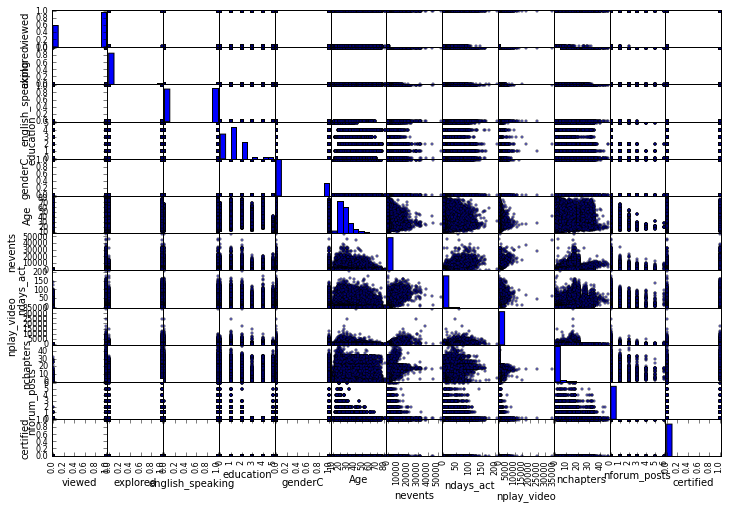

In [11]:
#CORR PLOT
_ = pd.scatter_matrix(corr.loc[:,'viewed':'certified'], figsize=(12,8))

# Building a classifier

## Dividing data to training and test set

In [12]:
# dividing data to training and testing
sss = StratifiedShuffleSplit(y, 3, test_size=0.25, random_state=110)
X1 = X.values
y1 = y.values
for train_index, test_index in sss:
    X_train, X_test = X1[train_index], X1[test_index]
    y_train, y_test = y1[train_index], y1[test_index]

In [13]:
print str(X_train.shape[0]) + ' training records'
print str(X_test.shape[0]) + ' test records'

401730 training records
133911 test records


## Classification

### Gradient boosting trees

In [23]:
# Gradient Boosting Classifier
gbc = ensemble.GradientBoostingClassifier()
gbc.fit(X_train, y_train)

/Users/aessa/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [24]:
# accuracy
training_accuracy = metrics.accuracy_score(y_train, gbc.predict(X_train))
testing_accuracy = metrics.accuracy_score(y_test, gbc.predict(X_test))
print "training and testing accuracies are: ", int(training_accuracy*100), "% and ", int(testing_accuracy*100),"%"

training and testing accuracies are:  98 % and  98 %


In [25]:
# Plot feature importance
feature_importance = gbc.feature_importances_

# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
feature_improtance_sorted = pd.DataFrame(feature_importance)
feature_improtance_sorted.columns = ['importance']
feature_improtance_sorted['features'] = ['viewed','explored','english_speaking','education','genderC','age','nevents','ndays_act','nplay_video','nchapters','nforum_posts']
feature_improtance_sorted = feature_improtance_sorted.sort(columns='importance',ascending = False)

In [26]:
feature_improtance_sorted

,importance,features
9,100.000000,nchapters
6,71.333733,nevents
8,45.635065,nplay_video
7,44.578380,ndays_act
5,27.976770,age
1,18.965438,explored
4,17.697804,genderC
10,4.864607,nforum_posts
3,4.196634,education
2,0.100393,english_speaking


In [27]:
data = Data([
    Bar(
        x=feature_improtance_sorted.features,
        y=feature_improtance_sorted.importance
    )
])
py.iplot(data, filename = 'feature importance')

## Normalize data

In [28]:
X_scaled = preprocessing.scale(X)
X_scaled_df = pd.DataFrame(X_scaled)
X_scaled_df.columns = ['viewed','explored','english_speaking','education','genderC','age','nevents','ndays_act','nplay_video','nchapters','nforum_posts']
X_scaled_df.describe()

,viewed,explored,english_speaking,education,genderC,age,nevents,ndays_act,nplay_video,nchapters,nforum_posts
count,5.356410e+05,5.356410e+05,5.356410e+05,5.356410e+05,5.356410e+05,5.356410e+05,5.356410e+05,5.356410e+05,5.356410e+05,5.356410e+05,5.356410e+05
mean,4.810191e-13,-1.275852e-13,2.831151e-13,4.340694e-14,-8.283623e-14,-3.324211e-14,-7.925187e-14,-3.893750e-14,1.837405e-13,1.022202e-13,-1.370519e-13
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-1.272249e+00,-2.493574e-01,-1.018845e+00,-1.015111e+00,-5.840613e-01,-2.015218e+00,-2.342724e-01,-4.070955e-01,-1.575992e-01,-5.503013e-01,-8.325004e-02
25%,-1.272249e+00,-2.493574e-01,-1.018845e+00,-1.015111e+00,-5.840613e-01,-6.529356e-01,-2.342724e-01,-4.070955e-01,-1.575992e-01,-5.503013e-01,-8.325004e-02
50%,7.860095e-01,-2.493574e-01,9.815037e-01,-1.183526e-01,-5.840613e-01,-3.123650e-01,-2.316625e-01,-3.037731e-01,-1.575992e-01,-2.855991e-01,-8.325004e-02
75%,7.860095e-01,-2.493574e-01,9.815037e-01,7.784055e-01,1.712149e+00,3.687761e-01,-1.820760e-01,-9.712835e-02,-1.471739e-01,-2.089683e-02,-8.325004e-02
max,7.860095e-01,4.010308e+00,9.815037e-01,3.468680e+00,1.712149e+00,6.158476e+00,4.602906e+01,2.077400e+01,1.801776e+02,1.189070e+01,3.933231e+01


# k-means Clustering

### Elbow Curve

In [29]:
##### cluster data into K=1..10 clusters #####
K = range(2,10)
KM = [kmeans(X_scaled,k) for k in K]
centroids = [cent for (cent,var) in KM]   # cluster centroids
avgWithinSS = [var for (cent,var) in KM] # mean within-cluster sum of squares

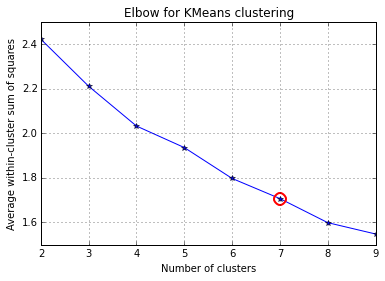

In [30]:
##### elbow curve #####
kIdx = 5
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(K, avgWithinSS, 'b*-')
ax.plot(K[kIdx], avgWithinSS[kIdx], marker='o', markersize=12, markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
plt.title('Elbow for KMeans clustering')
fig.savefig("elbow.png")
plt.show()

### Clustering

In [31]:
##### k-means #####
k = 7
km = KMeans(n_clusters = k)
km.fit(X_scaled_df)
cluster = pd.DataFrame(km.labels_)
cluster.columns = ['ClusterLabel']
cluster = X.join(cluster)

In [32]:
cluster = y.join(cluster)
cluster.head()

,certified,viewed,explored,english_speaking,education,genderC,Age,nevents,ndays_act,nplay_video,nchapters,nforum_posts,ClusterLabel
0,0,0,0,0,0,0,25,0,0,0,0,0,0
1,0,0,0,1,0,1,44,0,0,0,0,0,4
2,0,0,0,1,1,0,23,6,3,0,0,0,0
3,0,0,0,0,2,0,34,0,0,0,0,0,0
4,0,1,0,1,0,0,19,107,8,7,2,0,1


In [ ]:
ClusterSize = pd.DataFrame({'Cluster Size':cluster[['ClusterLabel']].groupby('ClusterLabel').size()}).reset_index()
ClusterSize

In [ ]:
alist = []
cluster = cluster.dropna()
for i in cluster['ClusterLabel'].unique():
    a = cluster[cluster['ClusterLabel']==i].mean()
    alist.append(a)
ClusterStats = pd.DataFrame(alist)
ClusterStats = ClusterStats.merge(ClusterSize,on='ClusterLabel')

In [ ]:
ClusterStats

* Group 5 with high certification rate has below characteristics:
    * very high number of events
    * High number of days active on the course
    * High number of viewed videos and completed chapters 

In [ ]:
cluster[['nevents','ClusterLabel']].boxplot(by='ClusterLabel')
plt.show()

In [ ]:
cluster[['ndays_act','ClusterLabel']].boxplot(by='ClusterLabel')
plt.show()

In [ ]:
cluster[['nplay_video','ClusterLabel']].boxplot(by='ClusterLabel')
plt.show()

In [ ]:
cluster[['nchapters','ClusterLabel']].boxplot(by='ClusterLabel')
plt.show()

### Function for Machine Learning

In [ ]:
def runModels(dataSet, featureArray, modelNum, answerCol):
# 1 for KNN
# 2 for Naive Bayes
# 3 for Logistic Regression
# 4 for random forest
    myFeatures = ''
    for i in (range(len(featureArray))): 
        myFeatures += featureArray[i] + ' ';
    dataSet['A'] = list(range(len(dataSet.index)))  
    testSampleSize = dataSet['A'].nunique()/5
    trainingSampleSize = dataSet['A'].nunique() - testSampleSize
    rows = random.sample(dataSet.A, int(testSampleSize))
    testData = dataSet[dataSet['A'].isin(rows)]
    trainingData = dataSet[dataSet['A'].isin(rows)==False]

   
    X = trainingData[featureArray]
    y = trainingData[answerCol]
    X_test = testData[featureArray]
    y_test = testData[answerCol]

    if modelNum == 1:
        modelName = 'KNN'
        clf = neighbors.KNeighborsClassifier(10, weights='uniform') #tried a few numbers for K, 10 gave best results
    
    if modelNum == 2:
        modelName = 'Naive Bayes'
        clf = gnb()

    if modelNum == 3:
        modelName = 'Logistic Regression'
        clf = LogisticRegression()

    if modelNum == 4:
        modelName = 'Random Forest'
        clf = rfc()
        
    if modelNum == 5:
        modelName = 'Gradient Boosting'
        clf = ensemble.GradientBoostingClassifier()
    
    clf = clf.fit(X,y)
    y_score = clf.predict(testData[featureArray])
    real = testData[answerCol]
    #RMSE= round(sqrt(sum(pow((predictions-real),2))/float(len(real))),2) #RMSE=0.290
    a=(y_score-real).tolist().count(1) #predicting "on task" on a "off task" student 
    b=  real.tolist().count(0)
    errOffTask = round(a/float(b),2)
    c=(y_score-real).tolist().count(-1) #predicting "off task" on a "on task"  students
    d=real.tolist().count(1)
    errOnTask =round( c/float(d),2)
    accuracy = round((y_score-real).tolist().count(0)/float(len(real)),2) #overall accuracy
    roc_Auc =  roc_auc_score(real, y_score)
    (p, r, f, s) = precision_recall_fscore_support(real, y_score, average='macro')
    print ('Results for '+ modelName)
    print ('Results for '+ myFeatures)
    #print ( 'RMSE = ' + str(RMSE))
    
    print ( 'AUC = ' + str(round(roc_Auc,2)))
    print ( 'Predicted "success" on a "failure" project: '+ str(a))
    print ('Total "failure" project: '+ str(b))
    print ('Predicted "failure" on a "success" project: '+ str(c))
    print ('Total "success" project: ' + str (d))
    print ('Error failure: '+ str(round(errOffTask,2)))
    print ('Error success: '+  str(round(errOnTask,2)))
    print ('Precision: '+  str(round(p,2)))
    print ('Recall: '+  str(round(r,2)))
    print ('Overall Accuracy: ' + str(accuracy))
    #return (roc_Auc, a, b, c, d, errOffTask, errOnTask, accuracy)
    
    # Compute ROC curve and ROC area for each class
#     fpr = dict()
#     tpr = dict()
#     roc_auc = dict()
#     for i in range(dataSet[answerCol].nunique()):
#         fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
#         roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
featureSet1= ['viewed','explored','english_speaking','education','genderC','Age','nevents','ndays_act','nplay_video','nchapters','nforum_posts','grade']
runModels(edx, featureSet1,2, 'certified')

In [ ]:
featureSet1= ['nevents','ndays_act','nchapters']
runModels(edx, featureSet1,3, 'certified')

In [ ]:
featureSet1= ['viewed','explored','english_speaking','education','genderC','Age','nevents','ndays_act','nplay_video','nchapters','nforum_posts','grade']
runModels(edx, featureSet1,1, 'certified')

In [ ]:
featureSet1= ['nevents','ndays_act','nchapters']
runModels(edx, featureSet1,4, 'certified')

In [ ]:
featureSet1= ['nevents']
runModels(edx, featureSet1,5, 'certified')